In [147]:
#conda install geopandas
import geopandas as gpd
import folium
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import networkx as nx
from sklearn import preprocessing
%matplotlib inline

In [149]:
#trip = pd.read_csv("trip.csv", parse_dates=['starttime','stoptime'], error_bad_lines=False)
trip = pd.read_csv("trip.csv")
station = pd.read_csv("station.csv")
weather = pd.read_csv("weather.csv")
seattle = gpd.read_file("Seattle_Streets/Seattle_Streets.shp")
# trip['year'] = trip['starttime'].apply(lambda x : x.year)
# trip['month'] = trip['starttime'].apply(lambda x : x.month)
# trip['day'] = trip['starttime'].apply(lambda x : x.day)
# trip['hour'] = trip['starttime'].apply(lambda x : x.hour)

### Graw cycle station network graph

We want to analyze on the connections of the different networks, so we filter out the trips where the 'from_station_id'and 'to_station_id' are the same to construct the network.

In [150]:
df_nx = trip.groupby(['from_station_id', 'to_station_id'], as_index=False)["trip_id"].count()
df_nx = df_nx.loc[df_nx.from_station_id!=df_nx.to_station_id]
df_nx.reset_index(drop=True,inplace=True)

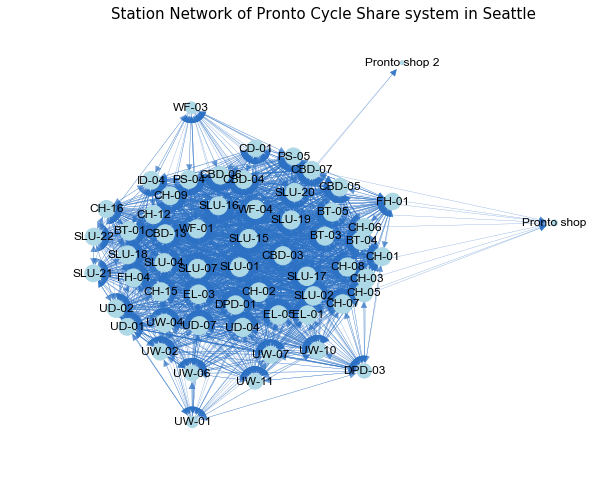

In [153]:
G = nx.from_pandas_edgelist(df_nx, source='from_station_id', target = 'to_station_id', edge_attr='trip_id', create_using=nx.DiGraph())

pos = nx.layout.kamada_kawai_layout(G) 

d = dict(G.degree)
M = G.number_of_edges()
edge_width = [0.001*G[u][v]['trip_id']+0.3 for u, v in G.edges()]
node_size = [(v+3)*3 for v in d.values()]

plt.figure(figsize=(10,8)) 
nodes = nx.draw_networkx_nodes(G, pos, node_size=node_size, node_color='lightblue')
edges = nx.draw_networkx_edges(G, pos, arrowstyle='-|>', arrowsize=15, edge_color='#2C71C4', width=edge_width, alpha=0.7)
# labels
labels = nx.draw_networkx_labels(G, pos, nodelist=d.keys(), font_size=12, font_family='Arial')

ax = plt.gca()
ax.set_axis_off()
plt.title("Station Network of Pronto Cycle Share system in Seattle", size='15')
plt.show();

### Visualize cycle share stations on the Seattle openstreet map with Folium

station.csv does not contain the following stations: **'Pronto shop','Pronto shop 2','8D OPS 02'**.  
We filter out these stations for plotting the map.

In [154]:
#station.csv does not contain the following stations: 'Pronto shop','Pronto shop 2','8D OPS 02'.
#We filter out these stations for plotting the map

trip_new = trip[(trip.from_station_id!='Pronto shop')&
   (trip.to_station_id!='Pronto shop')&
   (trip.from_station_id!='Pronto shop 2')&
   (trip.to_station_id!='Pronto shop 2')&
   (trip.from_station_id!='8D OPS 02')&
   (trip.to_station_id!='8D OPS 02')]

In [155]:
#plot seattle city map with folium openstreetmap

# long min : -122.35523 long max : -122.28411899999999
# lat min : 47.598488 lat max : 47.666145

sea_map = folium.Map(width=600, height=400, location=[47.64, -122.30],
                        zoom_start=12,
                        tiles='openstreetmap')
sea_map.fit_bounds([[47.595, -122.36], [47.673, -122.28]])      

for i in station.index:
    lat = station.lat[i]
    long = station.long[i]
    station_name = station.station_id[i]
    marker = folium.vector_layers.CircleMarker([lat, long], radius=5, 
                                         color = '#4f98f7',
                                         fill=True, 
                                         fill_color='#4f98f7',
                                         fill_opacity=1,
                                         tooltip=station_name).add_to(sea_map)
    
sea_map

### Visualize nodes(stations) and edges(bikes' trips between stations) on the Seattle city map

In [39]:
# lat, long, frequency
df_from = pd.merge(trip_new,station,left_on='from_station_id',right_on="station_id",how="left")
df_from_to = pd.merge(df_from, station, left_on='to_station_id',right_on="station_id",how="left")
df_from_to_lat_long = df_from_to[["from_station_id","to_station_id","lat_x","long_x","lat_y","long_y"]]
df_from_to_lat_long = df_from_to_lat_long[(df_from_to_lat_long.from_station_id!=df_from_to_lat_long.to_station_id)]

temp_x = []
for z in zip(df_from_to_lat_long.lat_x, df_from_to_lat_long.long_x):
    temp_x.append(z)
temp_y = []
for z in zip(df_from_to_lat_long.lat_y, df_from_to_lat_long.long_y):
    temp_y.append(z)
line = []
for x,y in zip(temp_x,temp_y):
    line.extend([[x,y]])
    
df_line  = pd.DataFrame(line,columns=['from','to'])
df_line["num"] = np.ones(len(line))
df_line_count = df_line.groupby(['from','to'], as_index=False)['num'].count()

location=[]
for x,y in zip(df_line_count['from'],df_line_count['to']):
    location.extend([[x,y]])

In [59]:
#plot seattle city map with folium openstreetmap

# long min : -122.35523 long max : -122.28411899999999
# lat min : 47.598488 lat max : 47.666145

min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(np.array(df_line_count.num).reshape(-1, 1))
norm_count = list(pd.DataFrame(x_scaled)[0])

sea_map = folium.Map(width=600, height=400, location=[47.64, -122.30],
                        zoom_start=12,
                        tiles='openstreetmap')
sea_map.fit_bounds([[47.595, -122.36], [47.673, -122.28]])      

# add edges
folium.vector_layers.PolyLine(locations = location, weight=0.4, opacity=0.3, color = '#2C71C4').add_to(sea_map)

# add nodes
for i in station.index:
    lat = station.lat[i]
    long = station.long[i]
    station_name = station.station_id[i]
    folium.vector_layers.CircleMarker([lat, long], radius=G.degree[station.station_id[i]]/20, 
                                         color = '#992FE7',
                                         fill=True, 
                                         fill_color='#992FE7',
                                         fill_opacity=0.5,
                                         tooltip=station_name).add_to(sea_map)
sea_map

### Draw network graph on static map with geopandas

In [8]:
#extract the coordinates from the map
def coords(geom):
    return list(geom.coords)

coords = seattle.apply(lambda row: coords(row.geometry), axis=1)

seattle['coords_long_1'] = [c[0][0] for c in coords]
seattle['coords_long_2'] = [c[1][0] for c in coords]
seattle['coords_lat_1'] = [c[0][1] for c in coords]
seattle['coords_lat_2'] = [c[1][1] for c in coords]

In [9]:
print("long min :",station.long.min(),"long max :",station.long.max())
print("lat min :",station.lat.min(),"lat max :",station.lat.max())

long min : -122.35523 long max : -122.28411899999999
lat min : 47.598488 lat max : 47.666145


In [10]:
# adjust the map boundary for the stations
map_region = seattle[(seattle.coords_long_1>=-122.36)&
            (seattle.coords_long_2<=-122.28)&
            (seattle.coords_lat_1>=47.595)&
            (seattle.coords_lat_2<=47.67)]

In [11]:
# prepare station network dataset

df = trip_new.groupby(['from_station_id', 'to_station_id'], as_index=False)["trip_id"].count()
df = df.loc[df.from_station_id!=df.to_station_id]
df.reset_index(drop=True,inplace=True)

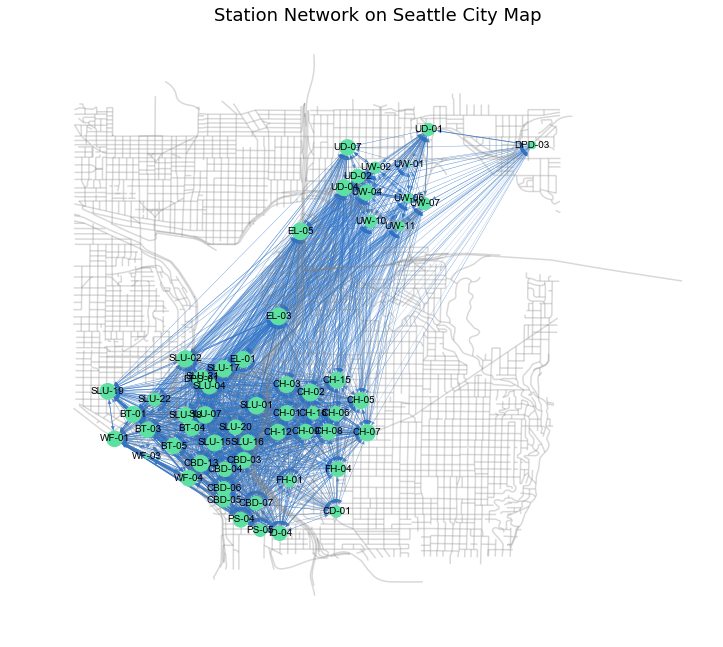

In [38]:
# large network
G = nx.from_pandas_edgelist(df, 
                            source='from_station_id', 
                            target = 'to_station_id', 
                            edge_attr='trip_id', 
                            create_using=nx.DiGraph())

# self define network position with the lat and long
position = {}
for i in range(len(station)):
    position[station.station_id[i]] = (station.long[i], station.lat[i])

pos = dict((node, position[node]) for node in G.nodes())

# plot network on the static map
fig, ax = plt.subplots(figsize=(12,12)); 
map_region.plot(ax=ax, alpha=0.3, color='grey');

# draw the network
d = dict(G.degree)
M = G.number_of_edges()
node_sizes = [(v**3/5000) for v in d.values()]
edge_width = [0.001*G[u][v]['trip_id']+0.2 for u, v in G.edges()]

nodes = nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color='#5DE1A3')
edges = nx.draw_networkx_edges(G, pos, arrowstyle='-|>', arrowsize=8, edge_color='#2C71C4', width=edge_width, alpha=0.7)
labels = nx.draw_networkx_labels(G, pos, nodelist=d.keys(), font_size=10, font_family='Arial', font_weight='500')

ax = plt.gca()
ax.set_axis_off()
plt.title("Station Network on Seattle City Map", size='18');

### draw temporal networks

In [61]:
# temporal dataset
y2014 = trip_new[trip_new['year'] == 2014]
y2015 = trip_new[trip_new['year'] == 2015]
y2016 = trip_new[trip_new['year'] == 2016]

y2015q1 = trip_new[(trip_new['year'] == 2015)&(trip_new['month'] <=3)&(trip_new['month'] >=1)]
y2015q2 = trip_new[(trip_new['year'] == 2015)&(trip_new['month'] <=6)&(trip_new['month'] >=4)]
y2015q3 = trip_new[(trip_new['year'] == 2015)&(trip_new['month'] <=9)&(trip_new['month'] >=7)]
y2015q4 = trip_new[(trip_new['year'] == 2015)&(trip_new['month'] <=12)&(trip_new['month'] >=10)]

y2016q1 = trip_new[(trip_new['year'] == 2016)&(trip_new['month'] <=3)&(trip_new['month'] >=1)]
y2016q2 = trip_new[(trip_new['year'] == 2016)&(trip_new['month'] <=6)&(trip_new['month'] >=4)]
y2016q3 = trip_new[(trip_new['year'] == 2016)&(trip_new['month'] <=9)&(trip_new['month'] >=7)]

In [62]:
df_y2014 = y2014.groupby(['from_station_id', 'to_station_id'], as_index=False)["trip_id"].count()
df_y2014 = df_y2014.loc[df_y2014.from_station_id!=df_y2014.to_station_id]
df_y2014.reset_index(drop=True,inplace=True)

df_y2015 = y2015.groupby(['from_station_id', 'to_station_id'], as_index=False)["trip_id"].count()
df_y2015 = df_y2015.loc[df_y2015.from_station_id!=df_y2015.to_station_id]
df_y2015.reset_index(drop=True,inplace=True)

df_y2016 = y2016.groupby(['from_station_id', 'to_station_id'], as_index=False)["trip_id"].count()
df_y2016 = df_y2016.loc[df_y2016.from_station_id!=df_y2016.to_station_id]
df_y2016.reset_index(drop=True,inplace=True)

In [68]:
year_list = [df_y2014, df_y2015, df_y2016]
quarter_list = [df_y2014,df_y2015q1,df_y2015q2,df_y2015q3,df_y2015q4,df_y2016q1,df_y2016q2,df_y2016q3]

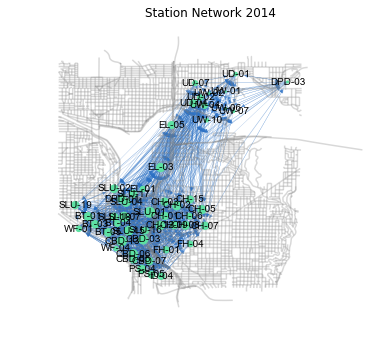

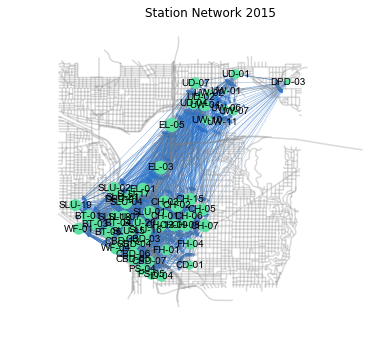

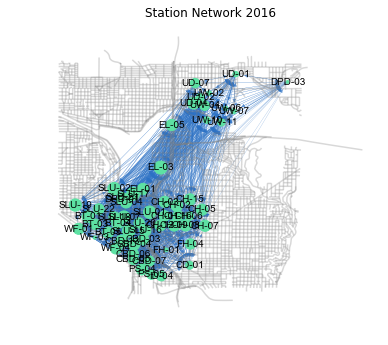

In [82]:
year = 2014

for dataframe in year_list:
    count += 1
    G = nx.from_pandas_edgelist(dataframe, 
                                source='from_station_id', 
                                target = 'to_station_id', 
                                edge_attr='trip_id', 
                                create_using=nx.DiGraph())

    # self define network position with the lat and long
    position = {}
    for i in range(len(station)):
        position[station.station_id[i]] = (station.long[i], station.lat[i])

    pos = dict((node, position[node]) for node in G.nodes())

    # plot network on the static map
    fig, ax = plt.subplots(figsize=(6,6)); 
    map_region.plot(ax=ax, alpha=0.3, color='grey');

    # draw the network
    d = dict(G.degree)
    M = G.number_of_edges()
    node_sizes = [(v**3/7000) for v in d.values()]
    edge_width = [0.001*G[u][v]['trip_id']+0.2 for u, v in G.edges()]

    nodes = nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color='#5DE1A3')
    edges = nx.draw_networkx_edges(G, pos, arrowstyle='-|>', arrowsize=8, edge_color='#2C71C4', width=edge_width, alpha=0.7)
    labels = nx.draw_networkx_labels(G, pos, nodelist=d.keys(), font_size=10, font_family='Arial', font_weight='500')

    ax = plt.gca()
    ax.set_axis_off()
    plt.title("Station Network {}".format(year), size='12');
    year += 1